## Import Libraries

In [1]:
import sys

sys.path.insert(1, '../')

import numpy as np
import pandas as pd
import scipy
import sklearn

from utils.arg_parser import *
from utils.import_data import *


from sne_example.method_sgn2 import *
from sne_example.method_gn import *
from sne_example.method_sgn import *
from sne_example.method_nspider import *
from sne_example.method_scgd import *


from matplotlib import pyplot as plt
import datetime, os, sys
import random

from sklearn.utils import resample

## Parse Arguments

In [2]:
# input arguments
sys.argv = ['sne_real_data.py', 
            '--obj', 'huber',      # objective type
            '-ne', '100',          # max num epochs
            '--seed', '42',        # seed
            '--alg', '1', '2','3', # algorithms to run 
            '--data', 'w8a',       # dataset name
            '--enable-log'         # save log data
           ]

# parse arguments
prog_option = argParser()

# extract options
is_plot         = prog_option["PlotOption"]
is_log          = prog_option["LogEnable"]
max_num_epochs  = prog_option["MaxNumEpoch"]
obj_type        = prog_option["Objective"]
seed_           = prog_option["Seed"]
dataset         = prog_option['Dataset']

alg_option = prog_option["Alg"]

## Input Preprocessing

In [3]:
# get data
X_data, Y_data = import_data(dataset)

# use sparse matrix for efficient computation
if not scipy.sparse.isspmatrix_csr(X_data):
    X_data = scipy.sparse.csr_matrix(X_data)

# get dimensions
n_ = X_data.shape[0]
d_ = X_data.shape[-1]

# prepare functions and data
Non_Linear_Func, Non_Linear_Data = intialize_func(4, X_data, Y_data)

if obj_type == 'l1':
    Objective_Func = {
        'Func': func_val_l1_norm,
        'Prox': prox_l1_norm,
        'DualFunc': ind_linf_ball,
        'DualProx': proj_linf_ball,
    }
elif obj_type == 'l2':
    Objective_Func = {
        'Func': func_val_l2_norm,
        'Prox': prox_l2_norm,
        'DualFunc': ind_l2_ball,
        'DualProx': proj_l2_ball,
    }
elif obj_type == 'huber':
    Objective_Func = {
        'Func': func_val_huber,
        'Prox': prox_huber,
        'Grad': grad_eval_huber,
    }

## Parameter Initializations

In [4]:
if obj_type == 'l2':
    sgn_jac_batch_size = 256
    sgn_func_batch_size = 512

    # sgn2
    sgn2_jac_batch_size = 64
    sgn2_func_batch_size = 128
    sgn2_jac_snap_batch_size = int(n_)
    sgn2_func_snap_batch_size = int(n_)
    sgn2_max_inner = 2000
elif obj_type == 'l1':
    sgn_jac_batch_size = 512
    sgn_func_batch_size = 1024

    # sgn2
    sgn2_jac_batch_size = 64
    sgn2_func_batch_size = 128
    sgn2_jac_snap_batch_size = int(n_)
    sgn2_func_snap_batch_size = int(n_)
    sgn2_max_inner = 2000
elif obj_type == 'huber':
    sgn_jac_batch_size = 256
    sgn_func_batch_size = 512

    # sgn2
    sgn2_jac_batch_size = 64
    sgn2_func_batch_size = 128
    sgn2_jac_snap_batch_size = int(n_)
    sgn2_func_snap_batch_size = int(n_)
    sgn2_max_inner = 5000

# Nested-SPIDER
nspider_jac_batch_size = 64
nspider_func_batch_size = 128
nspider_jac_snap_batch_size = int(n_)
nspider_func_snap_batch_size = int(n_)
nspider_max_inner = 5000
nspider_lr = 1.0

# SCGD
scgd_jac_batch_size = 256
scgd_func_batch_size = 512
scgd_lr = 1.0

# general problem parameters
if obj_type == 'l1':
    sub_prob_params = {
        'rho': 5.0,
        'M_const': 5.0,
        'epsilon': 1e-6,
        'max_sub_iter': 100,
        'RelTolSoln': 1e-6, 
        'sub_solver': 'adpg',
    }
elif obj_type == 'l2':
    sub_prob_params = {
        'rho': 5.0,
        'M_const': 5.0,
        'epsilon': 1e-6,
        'max_sub_iter': 100,
        'RelTolSoln': 1e-6, 
        'sub_solver': 'adpg',
    }
else:
    sub_prob_params = {
    'rho': 0.9,
    'M_const': 0.9,
    'epsilon': 1e-6,
    'max_sub_iter': 100,
    'RelTolSoln': 1e-6, 
    'sub_solver': 'adpg',
}

# gn
gn_params = {
    'max_epochs':max_num_epochs,
}

# sgn
sgn_params = {
    'jac_batch': sgn_jac_batch_size,
    'func_batch': sgn_func_batch_size,
    'max_epochs':max_num_epochs,
}

# sgn2
sgn2_params = {
    'jac_batch': sgn2_jac_batch_size,
    'func_batch': sgn2_func_batch_size,
    'jac_snap_batch': sgn2_jac_snap_batch_size,
    'func_snap_batch': sgn2_func_snap_batch_size,
    'max_inner': sgn2_max_inner,
    'max_epochs':max_num_epochs,
}

# nested-spider
nspider_params = {
    'jac_batch': nspider_jac_batch_size,
    'func_batch': nspider_func_batch_size,
    'jac_snap_batch': nspider_jac_snap_batch_size,
    'func_snap_batch': nspider_func_snap_batch_size,
    'max_inner': nspider_max_inner,
    'max_epochs':max_num_epochs,
    'lr': nspider_lr,
    'epsilon': 1e-2,
}

# scgd
scgd_params = {
    'jac_batch': scgd_jac_batch_size,
    'func_batch': scgd_func_batch_size,
    'max_epochs': max_num_epochs,
    'lr': scgd_lr,
}

## Initial Point

In [5]:
# set seed
np.random.seed(seed_)

# generate initial point
x0 = np.ones(d_)

## Run Algorithms

In [6]:
# init history
history = []
legend_list = []
log_dir = []

# initialize log directory
example_name = 'SNE'
dataset = prog_option['Dataset']

### GN

In [7]:
# GN
hist = sne_gn(x0, Objective_Func, Non_Linear_Func, Non_Linear_Data, sub_prob_params, gn_params)
log_dir = os.path.join('log_file',example_name,dataset,obj_type,'GN', 
                "gn_rho_" + str(sub_prob_params['rho']) + "_M_" +str(sub_prob_params['M_const'])
                    + "_ne_{:d}".format(max_num_epochs))
if is_log:
    print('Saved to',log_dir)
    save_history(log_dir, hist)
history.append(hist)
legend_list.append('GN')


GN Algorithm

    Time     |  # Epochs  |   # Samples   |   Obj. Val.   |  ||G_M(x)||   | Rel. Sol. Ch.
------------------------------------------------------------------------------------------
  1.23e-01   |    0.0     |   0.000e+00   |   4.111e+00   |   1.757e-01   |      inf     
  2.57e-01   |    2.0     |   9.950e+04   |   4.077e+00   |   1.801e-01   |   1.169e-02  
  3.64e-01   |    4.0     |   1.990e+05   |   4.041e+00   |   1.848e-01   |   1.207e-02  
  4.60e-01   |    6.0     |   2.985e+05   |   4.003e+00   |   1.899e-01   |   1.248e-02  
  5.51e-01   |    8.0     |   3.980e+05   |   3.963e+00   |   1.954e-01   |   1.293e-02  
  6.51e-01   |    10.0    |   4.975e+05   |   3.921e+00   |   2.013e-01   |   1.341e-02  
  7.47e-01   |    12.0    |   5.970e+05   |   3.876e+00   |   2.078e-01   |   1.393e-02  
  8.33e-01   |    14.0    |   6.965e+05   |   3.828e+00   |   2.149e-01   |   1.450e-02  
  9.24e-01   |    16.0    |   7.960e+05   |   3.776e+00   |   2.227e-01   |   1.512e

### SGN

In [8]:
# SGN
hist = sne_sgn(x0, Objective_Func, Non_Linear_Func, Non_Linear_Data, sub_prob_params, sgn_params)
log_dir = os.path.join('log_file',example_name,dataset,obj_type,'SGN', 
                "sgn_rho_" + str(sub_prob_params['rho']) + "_M_" +str(sub_prob_params['M_const'])
                + "_b1_" + str(sgn_params['jac_batch']) + "_b2_" + str(sgn_params['func_batch'])
                    + "_ne_{:d}".format(max_num_epochs))
if is_log:
    print('Saved to',log_dir)
    save_history(log_dir, hist)
history.append(hist)
legend_list.append('SGN')


SGN Algorithm

    Time     |  # Epochs  |   # Samples   |   Obj. Val.   |  ||G_M(x)||   | Rel. Sol. Ch.
------------------------------------------------------------------------------------------
  9.93e-02   |    0.0     |   0.000e+00   |   4.111e+00   |   1.757e-01   |      inf     
  1.40e+00   |    2.0     |   9.984e+04   |   2.023e-01   |   3.318e-02   |   3.012e-03  
  2.66e+00   |    4.0     |   1.997e+05   |   7.668e-02   |   1.294e-02   |   1.230e-03  
  3.88e+00   |    6.0     |   2.995e+05   |   6.587e-02   |   5.201e-03   |   9.197e-04  
  5.20e+00   |    8.0     |   3.994e+05   |   6.216e-02   |   3.795e-03   |   7.260e-04  
  6.53e+00   |    10.0    |   4.992e+05   |   6.047e-02   |   3.082e-03   |   9.298e-04  
  7.98e+00   |    12.0    |   5.990e+05   |   5.840e-02   |   2.665e-03   |   7.513e-04  
  9.36e+00   |    14.0    |   6.989e+05   |   5.811e-02   |   2.258e-03   |   6.055e-04  
  1.06e+01   |    16.1    |   7.987e+05   |   5.825e-02   |   2.127e-03   |   7.361

### SGN2

In [9]:
# SGN2
hist = sne_sgn2(x0, Objective_Func, Non_Linear_Func, Non_Linear_Data, sub_prob_params, sgn2_params)
log_dir = os.path.join('log_file',example_name,dataset,obj_type,'SGN2', 
                "sgn2_rho_" + str(sub_prob_params['rho']) + "_M_" +str(sub_prob_params['M_const'])
                    + "_b1_" + str(sgn2_params['jac_batch']) + "_b2_" + str(sgn2_params['func_batch']) 
                    + "_inner_" + str(sgn2_params['max_inner'])+ "_ne_{:d}".format(max_num_epochs))
if is_log:
    print('Saved to',log_dir)
    save_history(log_dir, hist)
history.append(hist)
legend_list.append('SGN2')


SGN2 Algorithm

    Time     |  # Epochs  |   # Samples   |   Obj. Val.   |  ||G_M(x)||   | Rel. Sol. Ch.
------------------------------------------------------------------------------------------
  7.09e-02   |    0.0     |   0.000e+00   |   4.111e+00   |   1.757e-01   |      inf     
  1.48e-01   |    4.0     |   1.990e+05   |   4.077e+00   |   1.801e-01   |   1.171e-02  
  1.48e+00   |    6.0     |   2.988e+05   |   8.431e-02   |   1.533e-02   |   1.211e-03  
  2.83e+00   |    8.0     |   3.987e+05   |   6.336e-02   |   4.683e-03   |   4.149e-04  
  4.24e+00   |    10.0    |   4.985e+05   |   5.983e-02   |   3.140e-03   |   2.785e-04  
  5.58e+00   |    12.0    |   5.984e+05   |   5.795e-02   |   2.339e-03   |   2.059e-04  
  6.90e+00   |    14.0    |   6.982e+05   |   5.674e-02   |   1.841e-03   |   1.621e-04  
  8.24e+00   |    16.0    |   7.980e+05   |   5.601e-02   |   1.507e-03   |   1.334e-04  
  9.51e+00   |    18.0    |   8.979e+05   |   5.542e-02   |   1.272e-03   |   1.13

### N-SPIDER

In [10]:
# N-SPIDER
if obj_type == 'huber':
    hist = sne_nspider(x0, Objective_Func, Non_Linear_Func, Non_Linear_Data, sub_prob_params, nspider_params)
    log_dir = os.path.join('log_file',example_name,dataset,obj_type,'N-SPIDER', 
                    "nspider_" + "lr_" + str(nspider_lr)
                        + "_b1_" + str(nspider_params['jac_batch']) + "_b2_" + str(nspider_params['func_batch']) 
                        + "_inner_" + str(nspider_params['max_inner'])+ "_ne_{:d}".format(max_num_epochs))
    if is_log:
        print('Saved to',log_dir)
        save_history(log_dir, hist)
    history.append(hist)
    legend_list.append('N-SPIDER')


N-SPIDER Algorithm

    Time     |  # Epochs  |   # Samples   |   Obj. Val.   |  ||G_M(x)||   | Rel. Sol. Ch.
------------------------------------------------------------------------------------------
  7.18e-02   |    0.0     |   0.000e+00   |   4.111e+00   |   1.759e-01   |      inf     
  1.47e-01   |    2.0     |   9.950e+04   |   4.111e+00   |   1.759e-01   |   5.775e-04  
  1.34e+00   |    4.0     |   1.993e+05   |   3.570e+00   |   2.559e-01   |   6.208e-04  
  2.49e+00   |    6.0     |   2.992e+05   |   2.762e+00   |   3.742e-01   |   6.524e-04  
  3.74e+00   |    8.0     |   3.990e+05   |   1.674e+00   |   4.350e-01   |   6.707e-04  
  4.87e+00   |    10.0    |   4.989e+05   |   6.767e-01   |   2.255e-01   |   6.801e-04  
  6.00e+00   |    12.0    |   5.987e+05   |   2.947e-01   |   4.759e-02   |   7.020e-04  
  7.11e+00   |    14.0    |   6.985e+05   |   2.156e-01   |   3.302e-02   |   7.541e-04  
  8.22e+00   |    16.0    |   7.984e+05   |   1.309e-01   |   3.500e-02   |   

### SCGD

In [11]:
# SCGD
if obj_type == 'huber':
    hist = sne_scgd(x0, Objective_Func, Non_Linear_Func, Non_Linear_Data, sub_prob_params, scgd_params)
    log_dir = os.path.join('log_file',example_name,dataset,obj_type,'SCGD', 
                    "scgd_" + "lr_" + str(nspider_lr)
                    + "_b1_" + str(sgn_params['jac_batch']) + "_b2_" + str(sgn_params['func_batch'])
                        + "_ne_{:d}".format(max_num_epochs))
    if is_log:
        print('Saved to',log_dir)
        save_history(log_dir, hist)
    history.append(hist)
    legend_list.append('SCGD')


SCGD Algorithm

    Time     |  # Epochs  |   # Samples   |   Obj. Val.   |  ||G_M(x)||   | Rel. Sol. Ch.
------------------------------------------------------------------------------------------
  8.79e-02   |    0.0     |   0.000e+00   |   4.111e+00   |   1.759e-01   |      inf     
  1.31e+00   |    2.0     |   9.984e+04   |   2.180e-01   |   3.367e-02   |   3.011e-03  
  2.44e+00   |    4.0     |   1.997e+05   |   8.724e-02   |   1.983e-02   |   2.007e-03  
  3.81e+00   |    6.0     |   2.995e+05   |   6.674e-02   |   6.079e-03   |   8.206e-04  
  5.04e+00   |    8.0     |   3.994e+05   |   6.369e-02   |   4.196e-03   |   8.186e-04  
  6.36e+00   |    10.0    |   4.992e+05   |   6.102e-02   |   3.342e-03   |   8.372e-04  
  7.71e+00   |    12.0    |   5.990e+05   |   5.945e-02   |   2.862e-03   |   7.095e-04  
  8.89e+00   |    14.0    |   6.989e+05   |   5.869e-02   |   2.502e-03   |   6.526e-04  
  1.01e+01   |    16.1    |   7.987e+05   |   5.830e-02   |   2.247e-03   |   7.17

## Plot Results

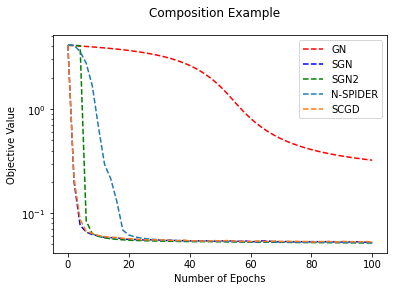

In [12]:
color = ['r','b','g']
color.extend(['C' + str(i) for i in range(10)])

fig1 = plt.figure()
# markfreq = 2
color_cnt = 0
for h in history:
    plt.semilogy(   np.array(h['Epochs']) ,
        np.array(h['Obj']) ,
        linestyle = '--',
        color = color[color_cnt],
                )
    color_cnt += 1

fig1.suptitle( 'Composition Example' )
plt.xlabel( "Number of Epochs" )
plt.ylabel( "Objective Value" )
plt.legend(legend_list)
plt.show()